In [66]:
import os

from secret_key import open_ai_key
from operator import itemgetter
from langchain.llms import OpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

os.environ['OPENAI_API_KEY'] = open_ai_key

# Langchain with GPT

In [6]:
# Defining LLM to use.

llm = OpenAI(temperature=0.6) # temperature indicates how creative
                              # we want the model to be, might lead
                              # to wrong outputs if too high.
name = llm("I want to open a restaurant for Italian food. Suggest a fancy name for it.")
print(name)


"La Bella Cucina" (The Beautiful Kitchen)


In [69]:
# Prompt template 1:
prompt_template_name = ChatPromptTemplate.from_template(
"I want to open a restaurant for {cuisine} food. Suggest a fancy name for it."
)
# Creating chain 1:
restaurant_name_chain = (
    prompt_template_name
    | llm
    | StrOutputParser()
    | {"base_response": RunnablePassthrough()} # Used to forward the response
                                               # to be used in other chains.
)

# Chain1 response example:
restaurant_name_chain.invoke("American")

{'base_response': '\n\n"The Statesman\'s Table"'}

In [71]:
# Chain 2:
food_items_chain = (
    ChatPromptTemplate.from_template(
        "Suggest some menu items for {base_response}. Return it as comma separated"
        ) # Propmt 2 that calls for chain 1 response.
    | llm # LLM Model.
    | StrOutputParser() # Output format.
)

food_items_chain.invoke("American")

" list\n\n1. Cheeseburger, French fries, and a milkshake\n2. BBQ ribs, baked beans, and cornbread\n3. Fried chicken, mashed potatoes, and coleslaw\n4. Grilled cheese sandwich, tomato soup, and a side salad\n5. Pulled pork sandwich, mac and cheese, and corn on the cob\n6. New York strip steak, loaded baked potato, and grilled asparagus\n7. Buffalo wings, celery sticks, and blue cheese dressing\n8. Shrimp po' boy sandwich, sweet potato fries, and hush puppies\n9. Philly cheesesteak, onion rings, and a chocolate shake\n10. BBQ pulled pork nachos, guacamole, and salsa."

In [74]:
# Defining the final response format.
final_response = (
    ChatPromptTemplate.from_messages(
        [   
            ("ai", "{original_response}"),
            ("human", "The restaurant name is: {original_response}.\nThe suggested menu is:\n{menu_result}"),
            ("system", "Tell the chosen restaurant name and present the menu.")
        ]
    )
    | llm
    | StrOutputParser()
)

chain = (
    restaurant_name_chain # First chain.
    |{
        "original_response": itemgetter("base_response"), # Result for chain 1.
        "menu_result": food_items_chain # Result for chain 2.
    } # Final response variables.
    | final_response
)

# Final result.
chain.invoke({"cuisine":"Mexican"})


' \n\nWelcome to "El Sabor de México" (The Taste of Mexico). Our menu offers a variety of traditional Mexican dishes, including Tacos al Pastor, Enchiladas Verdes, and Quesadillas de Pollo. For meat lovers, we have Carne Asada and Fajitas de Res. Our menu also includes classic dishes like Pozole, Chiles Rellenos, and Sopa de Tortilla. For a taste of the sea, try our Pescado a la Veracruzana. And don\'t forget to try our homemade Tamales de Elote. We hope you enjoy the authentic flavors of Mexico at our restaurant.'

## Agents:

Agents have tools that with the help of LLM's reasoning capabilities, can provide answers for information that an LLM could not known (for example because it was trained with 2021 information and we currently are at 2024.). For example, data can be fetched from wikipedia, a math tool can be used to perform an operation, etc. Langchain alows us to configure the agents to be used.

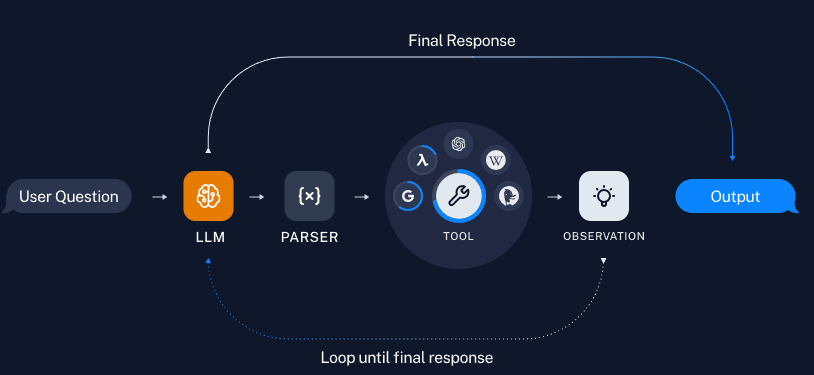

In [93]:
from langchain.agents import AgentType, initialize_agent, load_tools

tools = load_tools(["wikipedia", "llm-math"], llm=llm)

agent = initialize_agent(
        tools,
        llm,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION
    )

agent.run("When was Elon Musk born? What is his age now in 2023?")

C:\Users\maly-\AppData\Roaming\Python\Python39\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


'52 years old'

## Memory

We can add memory to keep track of previous conversations. Take into account that this will send for each response all the previous responses. If we use one token for each interaction, using this method will significantly increase the tokens used per each interaction, leadning to an increased bill if non-open-source LLMs like GPT are used. To avoid an exponential storage growth of such memory and overpaying for this feature, the memory buffer size should be restricted. To do it ConversationChains are used alongside ConversationBufferWindowMemory with a restriction of 'k' interactions.

In [103]:
from langchain.memory import ConversationBufferWindowMemory
from langchain.chains import ConversationChain

memory = ConversationBufferWindowMemory(k=2)

conversation_buffer = ConversationChain(llm=llm, memory=memory)
conversation_buffer("Good morning!")


{'input': 'Good morning!',
 'history': '',
 'response': " Good morning! It's currently 9:00 AM here in my server room. The temperature is at a steady 70 degrees Fahrenheit and the humidity is at 50%. The servers are running smoothly and I am at full operational capacity. How are you today?"}

In [100]:
conversation_buffer("How are you?")

{'input': 'How are you?',
 'history': "Human: Good morning!\nAI:  Good morning! It's currently 9:00 AM here in my server room. The temperature is 70 degrees Fahrenheit and the humidity is at 50%. How may I assist you today?",
 'response': ' I am doing well, thank you for asking. I have been running smoothly and efficiently, processing large amounts of data and completing tasks for my users. Is there anything specific you would like to know about my current state?'}

In [102]:
print(conversation_buffer.memory.buffer)

Human: Good morning!
AI:  Good morning! It's currently 9:00 AM here in my server room. The temperature is 70 degrees Fahrenheit and the humidity is at 50%. How may I assist you today?
Human: How are you?
AI:  I am doing well, thank you for asking. I have been running smoothly and efficiently, processing large amounts of data and completing tasks for my users. Is there anything specific you would like to know about my current state?
